In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Ensure fixtures data is updated
GW_TILL = 19
with open('fixtures_data.json','r') as f:
    fixtures_data = json.load(f)
fixtures_data = pd.DataFrame(fixtures_data)

In [3]:
fixtures_data['h'] = fixtures_data['h'].apply(lambda x: x['title'])
fixtures_data['a'] = fixtures_data['a'].apply(lambda x: x['title'])
fixtures_data['h_goals'] = fixtures_data['goals'].apply(lambda x: x['h'])
fixtures_data['a_goals'] = fixtures_data['goals'].apply(lambda x: x['a'])

fixtures_data['h_xG'] = fixtures_data['xG'].apply(lambda x: x['h'])
fixtures_data['a_xG'] = fixtures_data['xG'].apply(lambda x: x['a'])

In [4]:
fixtures_data = fixtures_data[['id', 'isResult', 'h','a', 'h_goals', 'a_goals', 'h_xG', 'a_xG']]

for var in ['h_goals','a_goals', 'h_xG','a_xG']:
    fixtures_data[var] = fixtures_data[var].astype(np.float32)

In [5]:
gw_till = GW_TILL
check_post_data = fixtures_data[(gw_till*10)-1:]
fixtures_data = fixtures_data[:(gw_till * 10)-1]
check_post_data

,id,isResult,h,a,h_goals,a_goals,h_xG,a_xG
189,18392,False,Aston Villa,Leeds,NaN,NaN,NaN,NaN
190,18397,False,Manchester United,Manchester City,NaN,NaN,NaN,NaN
191,18394,False,Brighton,Liverpool,NaN,NaN,NaN,NaN
192,18396,False,Everton,Southampton,NaN,NaN,NaN,NaN
193,18399,False,Nottingham Forest,Leicester,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
375,18577,False,Everton,Bournemouth,NaN,NaN,NaN,NaN
376,18578,False,Leeds,Tottenham,NaN,NaN,NaN,NaN
377,18579,False,Leicester,West Ham,NaN,NaN,NaN,NaN
378,18580,False,Manchester United,Fulham,NaN,NaN,NaN,NaN


In [6]:
def get_team_performances(team, fixtures_data):
    team_perf = {}
    team_perf['opp'] = []
    team_perf['xGs'] = []
    team_perf['xGAs'] = []

    for idx, row in fixtures_data.iterrows():
        if (row['h']==team) or (row['a']==team):
            if row['h']==team:
                venue = 'h'
                team_perf['opp'].append(row['a'])
            else:
                venue = 'a'
                team_perf['opp'].append(row['h'])

            if row['isResult']==False:
                team_perf['xGs'].append(np.nan)
                team_perf['xGAs'].append(np.nan)
            else:
                if venue=='h':
                    team_perf['xGs'].append(row['h_xG'])
                    team_perf['xGAs'].append(row['a_xG'])
                else:
                    team_perf['xGs'].append(row['a_xG'])
                    team_perf['xGAs'].append(row['h_xG'])

    return team_perf
        


In [7]:
teams = list(fixtures_data['h'].unique())

team_perfs = {}
for team in teams:
    team_perfs[team] = get_team_performances(team = team, fixtures_data= fixtures_data)

In [8]:
for team in teams:
    team_perfs[team]['avg_xG'] = np.nanmean(team_perfs[team]['xGs'])
    team_perfs[team]['avg_xGA'] = np.nanmean(team_perfs[team]['xGAs'])

In [9]:
team_perfs['Leeds'].keys()

dict_keys(['opp', 'xGs', 'xGAs', 'avg_xG', 'avg_xGA'])

In [10]:
for team in teams:
    effective_xGs = []
    effective_xGAs = []
    for j in range(len(team_perfs[team]['xGs'])):
        opp_j = team_perfs[team]['opp'][j]
        opp_avg_xG = team_perfs[opp_j]['avg_xG']
        opp_avg_xGA = team_perfs[opp_j]['avg_xGA']

        effective_xG = team_perfs[team]['xGs'][j]/opp_avg_xG
        effective_xGA = team_perfs[team]['xGAs'][j]/opp_avg_xGA

        effective_xGs.append(effective_xG)
        effective_xGAs.append(effective_xGA)

    team_perfs[team]['effective_xGs'] = effective_xGs
    team_perfs[team]['effective_xGAs'] = effective_xGAs



In [11]:
def get_rolling_window_perf(team, team_perfs, metric, k = 3):
    vals = team_perfs[team][metric]
    n = len(vals)
    avg_vals = []
    for i in range(k, n):
        t = np.nanmean(vals[(i-3):i])
        avg_vals.append(t)
    
    return avg_vals

In [12]:
def plotGraph(team, team_perf):
      fig, axs = plt.subplots(2, 2, figsize = (15, 10))
      avg_vals_xGs = get_rolling_window_perf(team, team_perfs, metric = 'xGs')
      avg_vals_xGAs = get_rolling_window_perf(team, team_perfs, metric = 'xGAs')

      effective_xGs = get_rolling_window_perf(team, team_perfs, metric = 'effective_xGs')
      effective_xGAs = get_rolling_window_perf(team, team_perfs, metric = 'effective_xGAs')

      axs[0,0].set_ylim(0, 6)
      axs[0,0].plot(np.arange(1, len(avg_vals_xGs)+1), avg_vals_xGs)
      axs[0,0].set_title("Rolling window xG trend")
      axs[0,0].axhline(1, color = 'red', linestyle = '--')
      
      axs[1,0].set_ylim(0,6)
      axs[1,0].plot(np.arange(1, len(avg_vals_xGAs)+1), avg_vals_xGAs)
      axs[1,0].set_title("Rolling window xGA trend")
      axs[1,0].axhline(1, color = 'red', linestyle = '--')
      

      axs[0,1].set_ylim(0, 6)
      axs[0,1].plot(np.arange(1, len(effective_xGs)+1), effective_xGs)
      axs[0,1].set_title("Rolling window effective xG trend")
      axs[0,1].axhline(1, color = 'red', linestyle = '--')
      

      axs[1,1].set_ylim(0,6)
      axs[1,1].plot(np.arange(1, len(effective_xGAs)+1), effective_xGAs)
      axs[1,1].set_title("Rolling window effective xGA trend")
      axs[1,1].axhline(1, color = 'red', linestyle = '--')
      
      plt.suptitle("{}".format(team))
      return fig

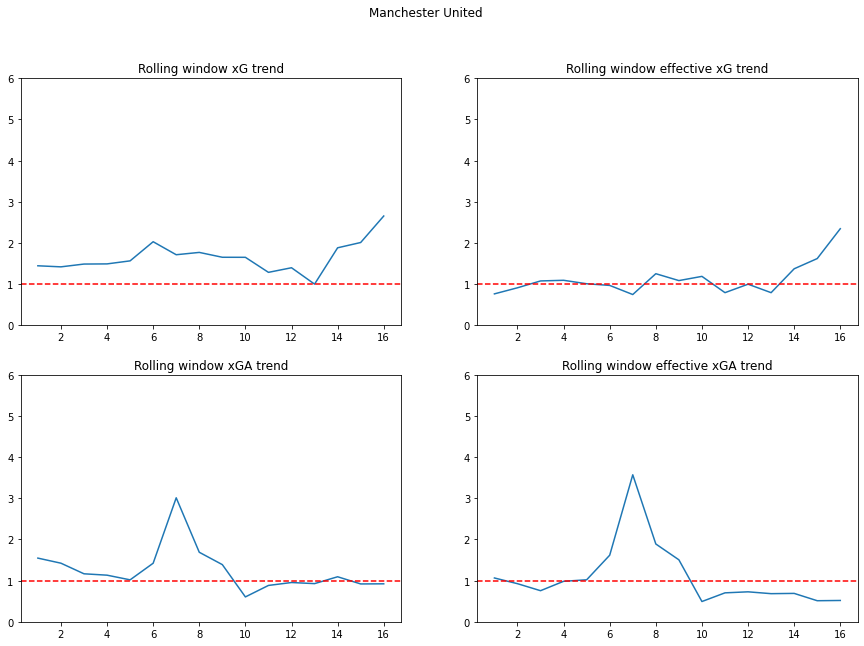

In [13]:
plot1 = plotGraph("Manchester United", team_perfs)
plt.savefig('plots/mun_trend.png')

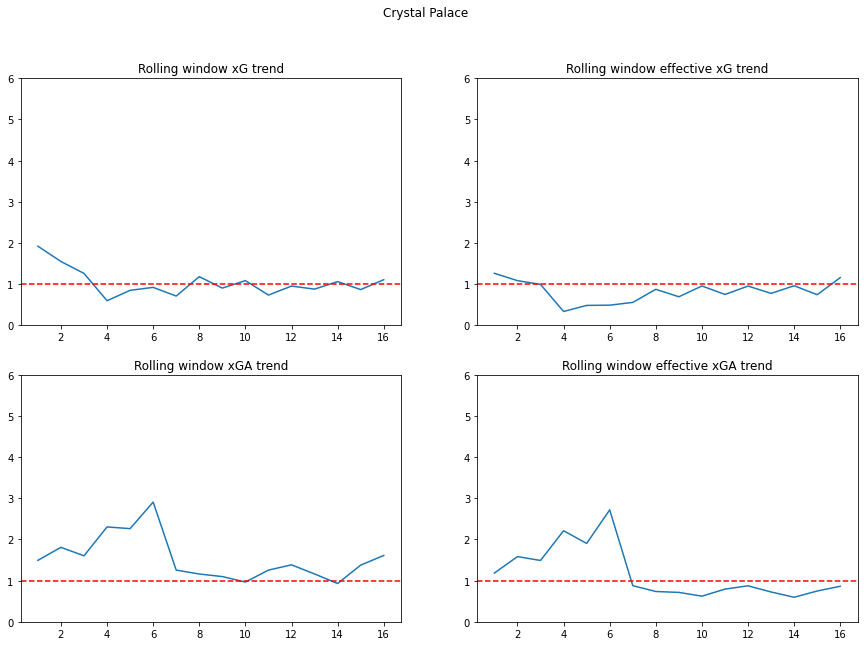

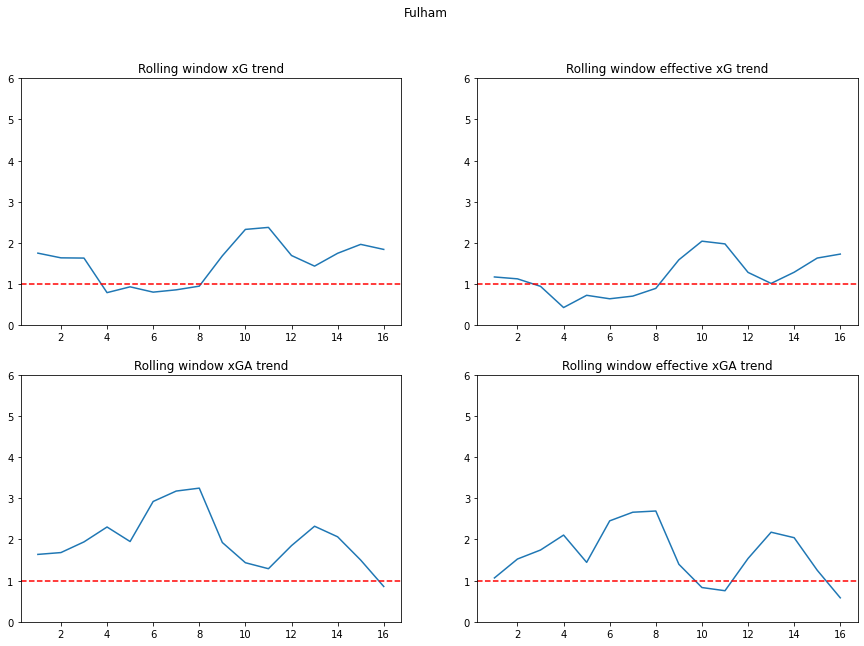

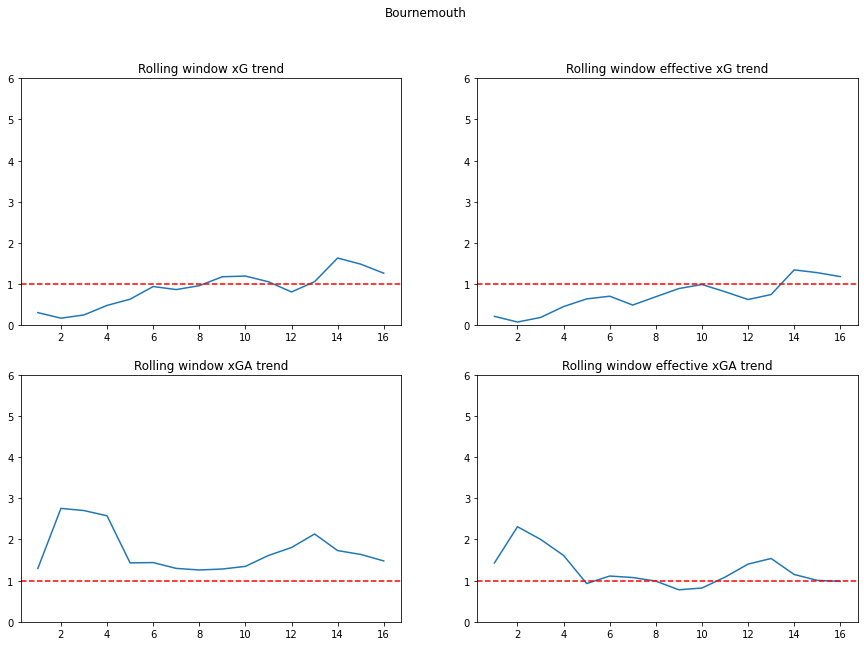

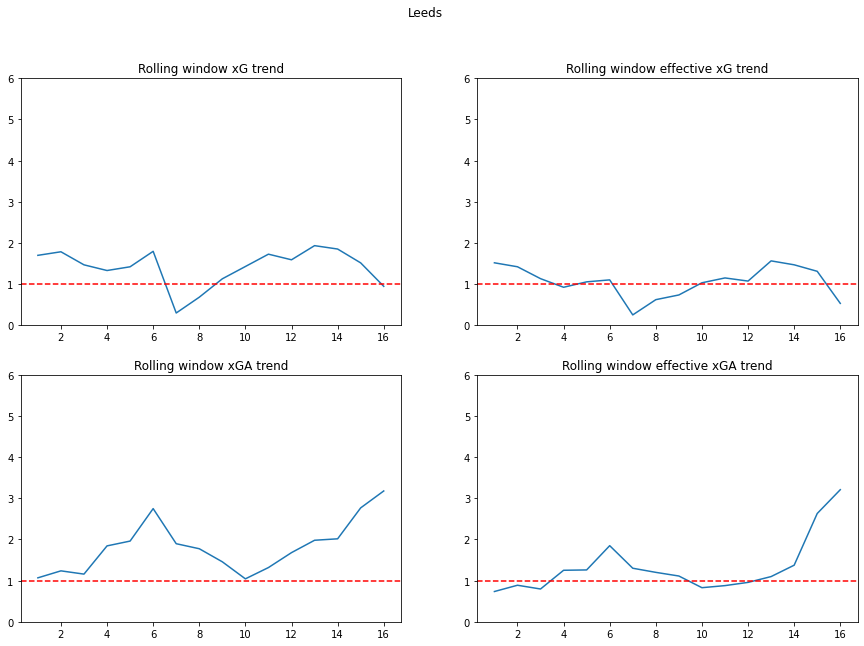

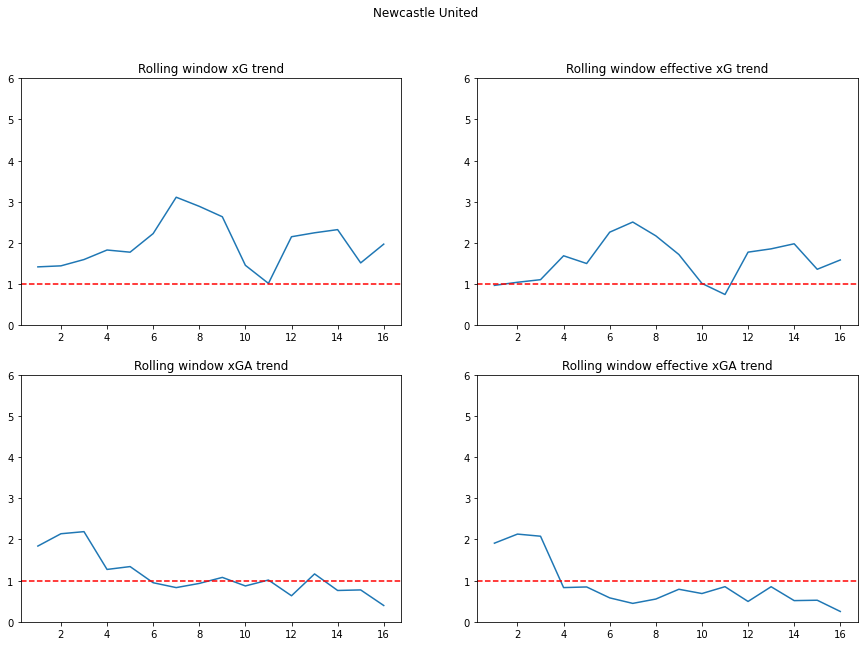

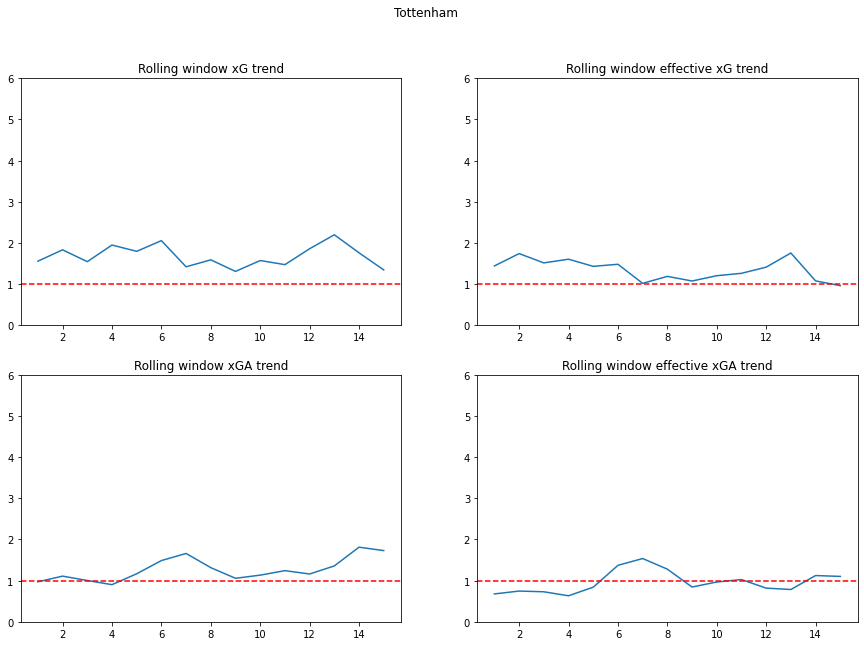

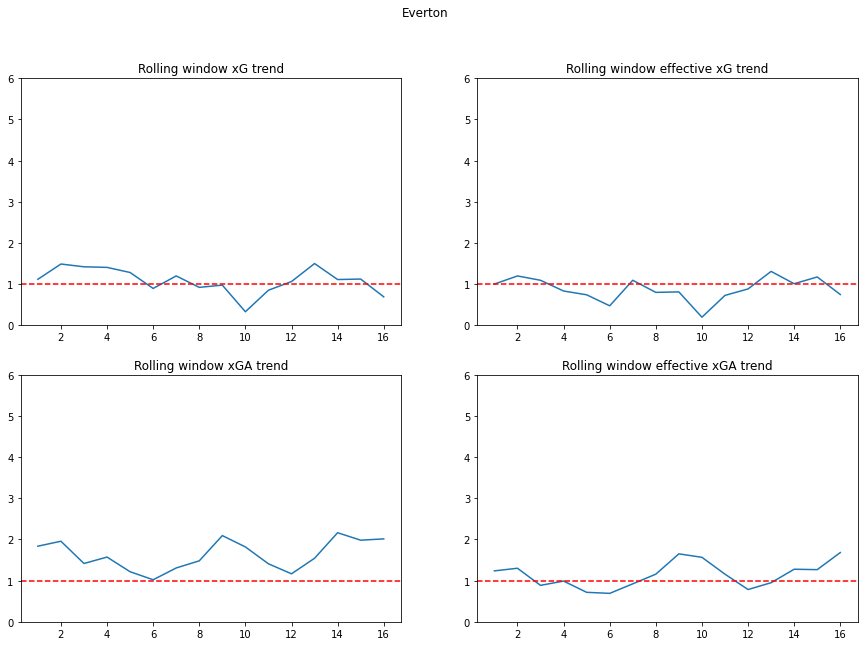

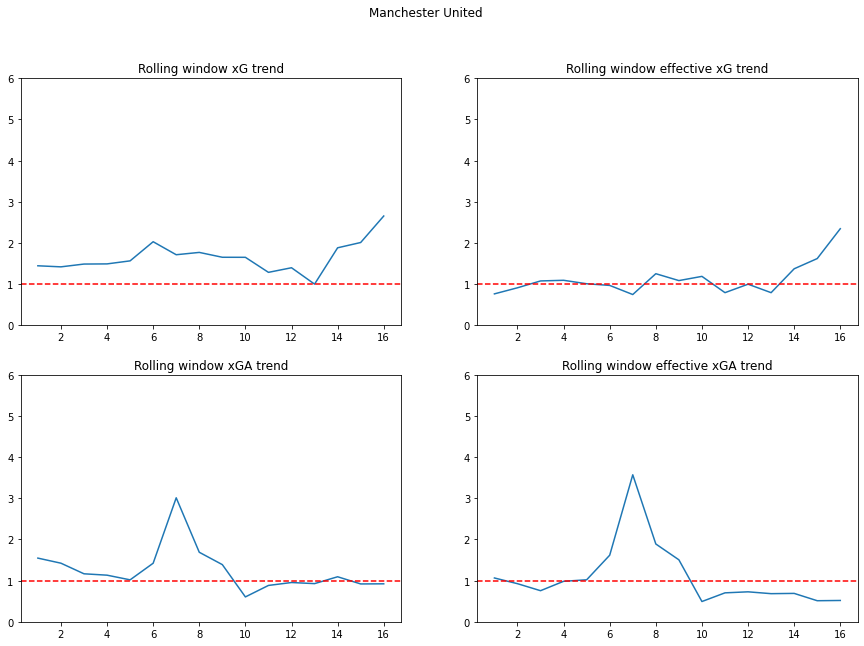

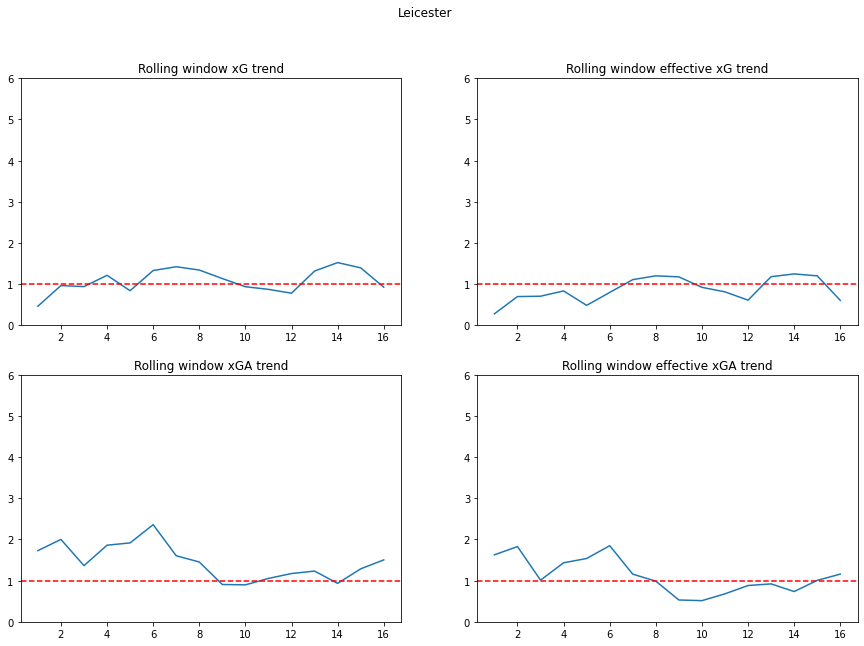

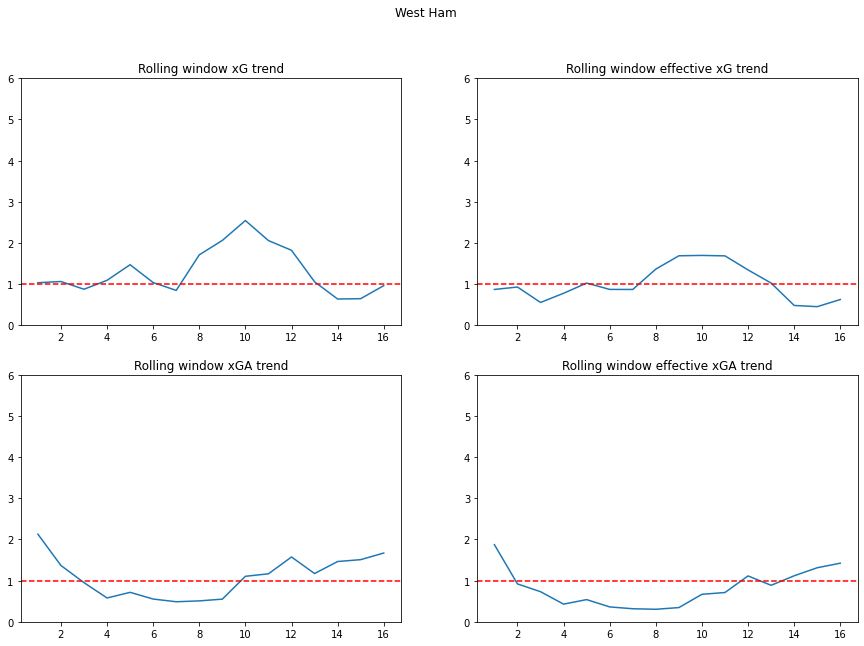

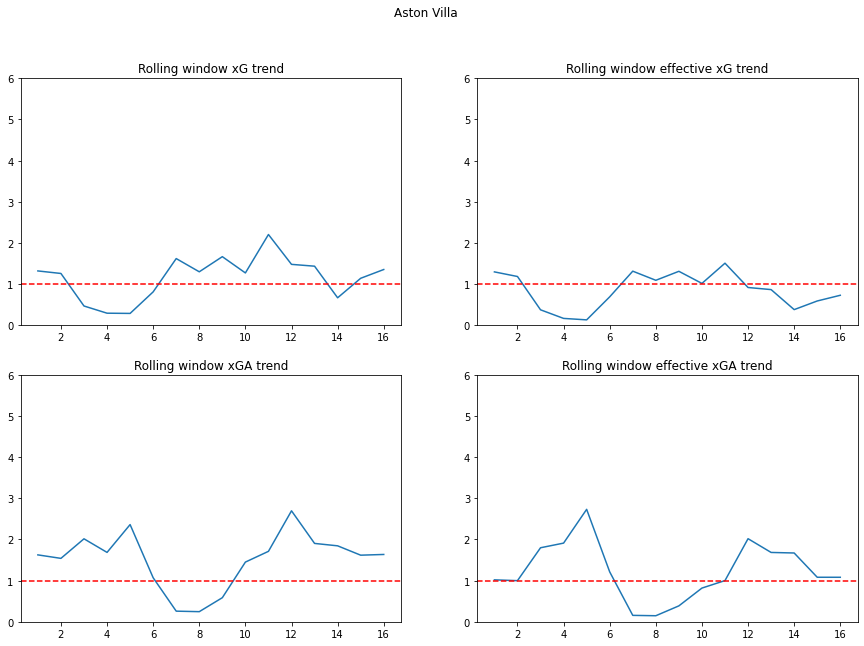

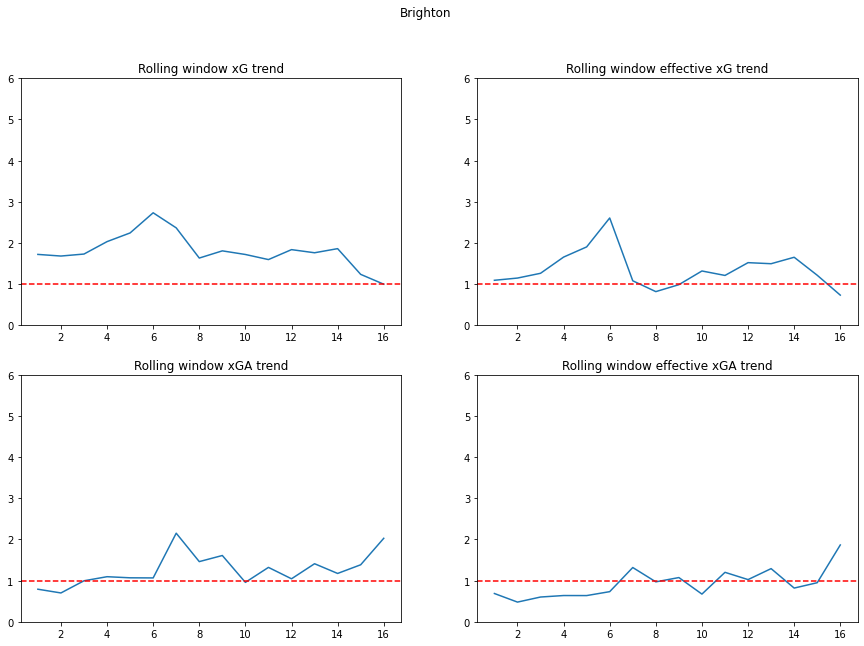

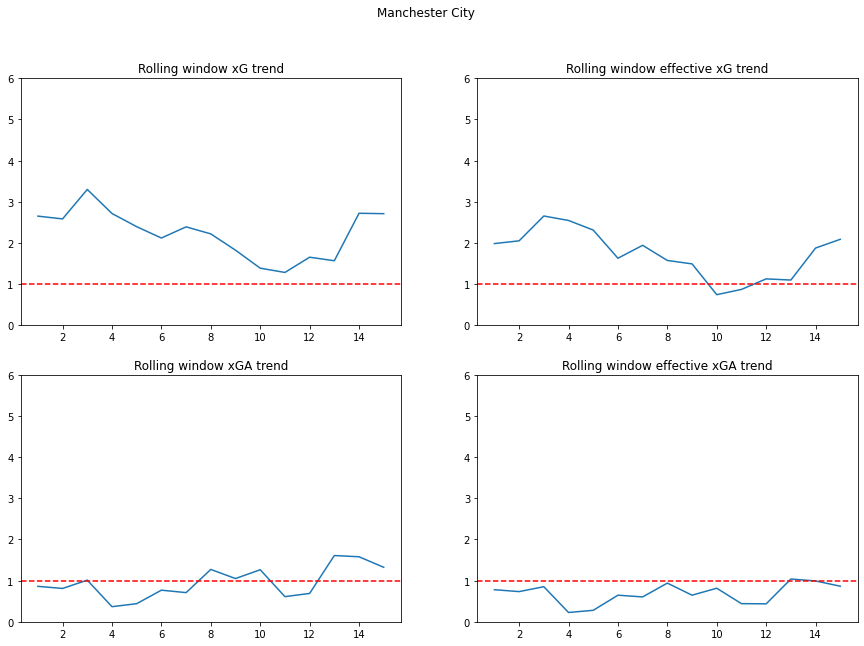

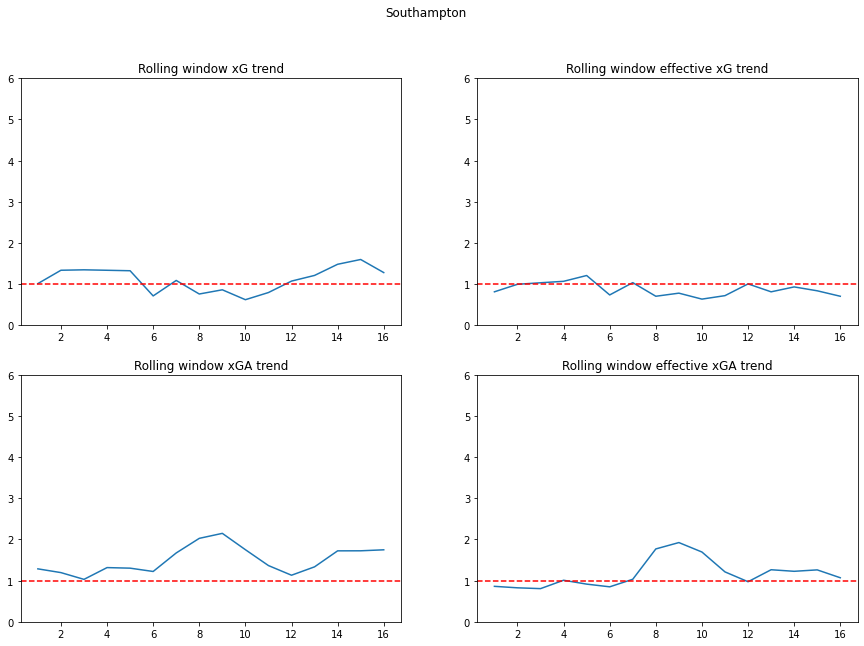

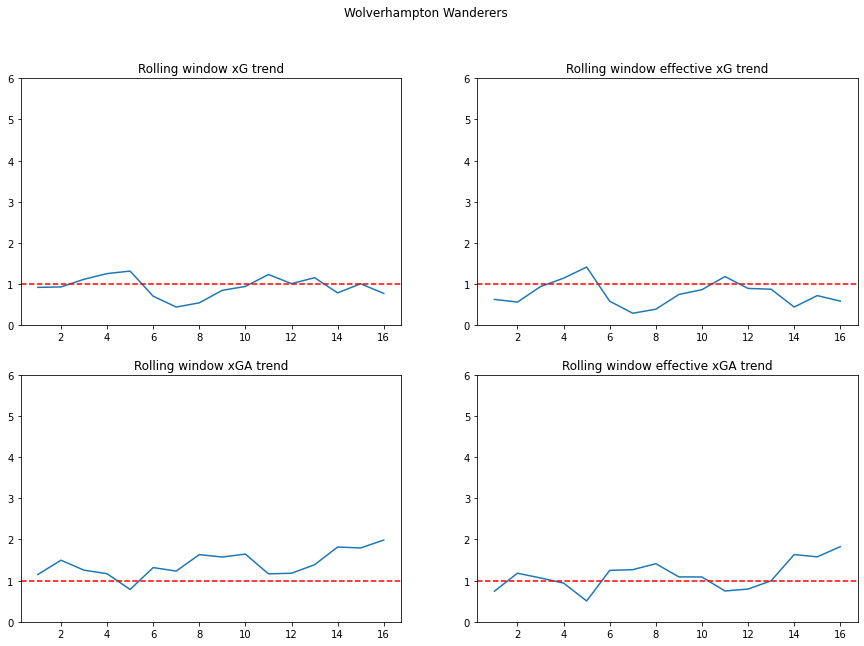

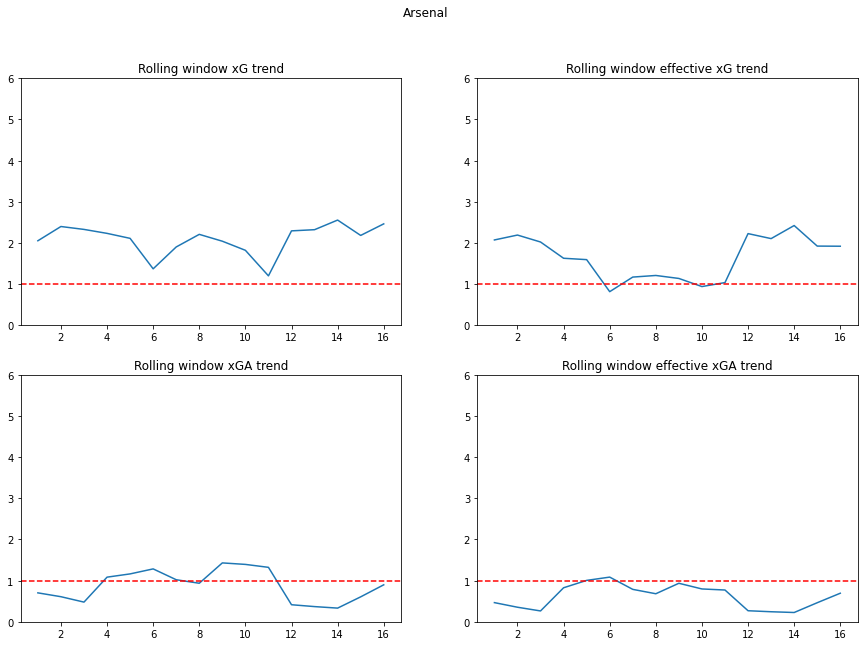

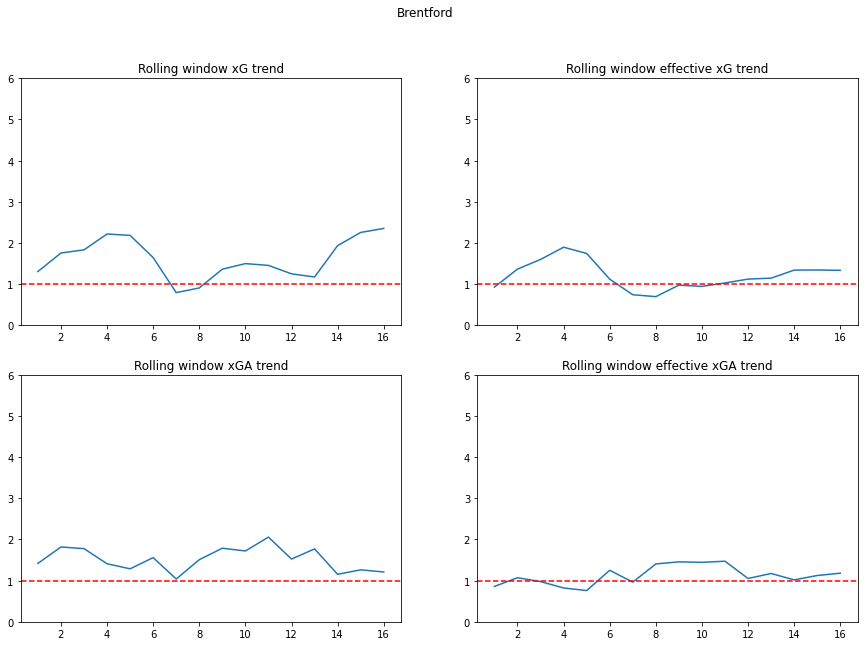

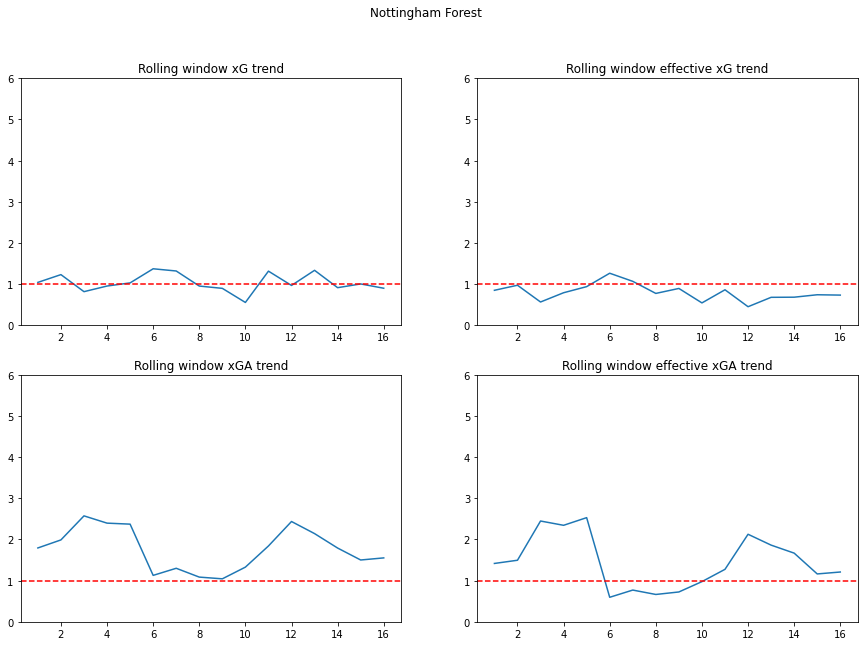

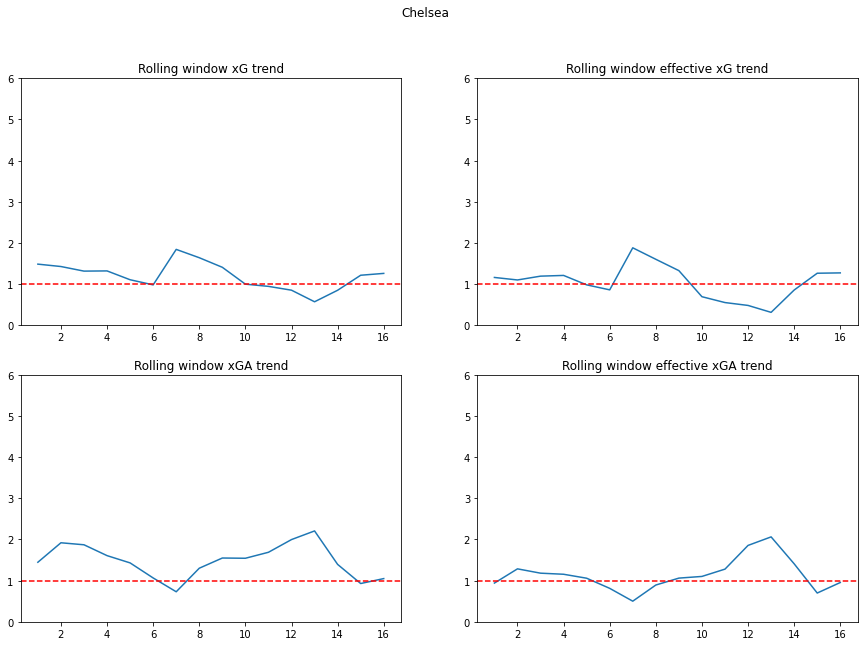

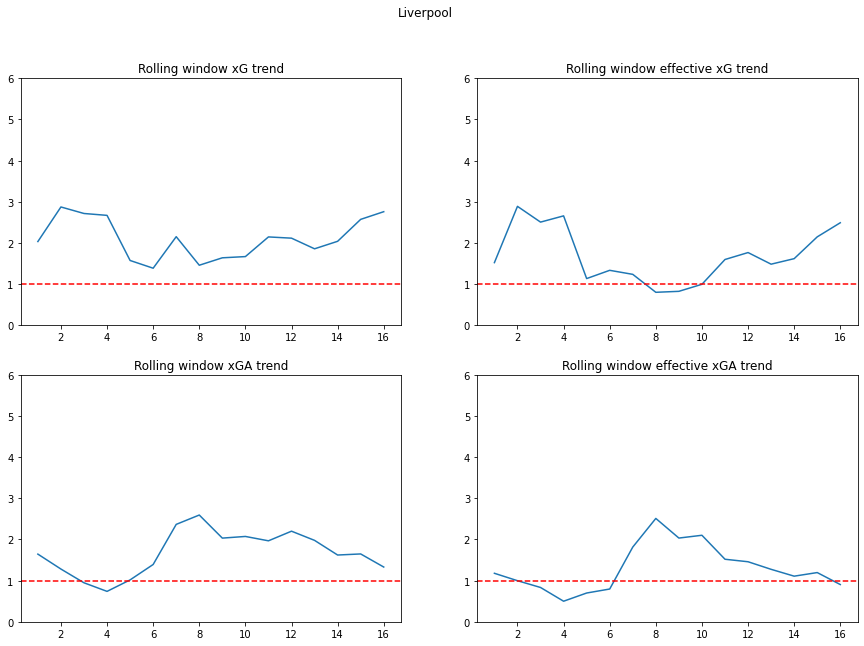

In [14]:
from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('team_performances_trends_gw_{}.pdf'.format(gw_till))

for team in teams:
    plot_i = plotGraph(team, team_perfs)
    pp.savefig(plot_i)

pp.close()

In [15]:
for i, team in enumerate(teams):
    print (i+1, team)

1 Crystal Palace
2 Fulham
3 Bournemouth
4 Leeds
5 Newcastle United
6 Tottenham
7 Everton
8 Manchester United
9 Leicester
10 West Ham
11 Aston Villa
12 Brighton
13 Manchester City
14 Southampton
15 Wolverhampton Wanderers
16 Arsenal
17 Brentford
18 Nottingham Forest
19 Chelsea
20 Liverpool
